In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

import xml.etree.ElementTree as ET
from sklearn.cluster import DBSCAN
import os
import random
import cv2

from ultralytics import YOLO
import torch.optim as optim
from torchvision.transforms import functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import sys

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, 'detections'))
from detection.engine import train_one_epoch, evaluate

random.seed(47)
torch.manual_seed(47)
np.random.seed(47)

### Loading the annotations in a dataframe

In [2]:
data = []

xml_folder = "dataset/labels - PASCAL VOC"

for xml_file in os.listdir(xml_folder):
    if xml_file.endswith(".xml"):
        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        # image files info
        size = root.find("size")
        width = int(size.find("width").text)

        # object info
        for obj in root.findall("object"):
            name = obj.find("name").text
            truncated = int(obj.find("truncated").text)

            # bounding box info
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            filename = root.find('filename').text.replace(".png", "")
            data.append({
                "filename": int(filename),
                "width": width,
                "name": name,
                "truncated": truncated,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax
            })

df = pd.DataFrame(data)
newdf = df.sort_values(by="filename")

print(len(df))
df.head(5)

5919


,filename,width,name,truncated,xmin,ymin,xmax,ymax
0,0,200,no parking,0,65,59,127,122
1,1,200,no entry,0,111,104,140,142
2,10,200,drive straight,0,57,81,101,143
3,100,200,no entry,0,73,62,143,134
4,1000,512,no entry,0,467,200,478,212


In [3]:
# dataframe adjustments

# we have a duplicated label that we can unify
df["name"] = df["name"].replace("maximum speed 10 km/h", "maximum speed 10km/h")


# replace names with fewer than 200 entries with "other"
name_counts = df["name"].value_counts()
df["name"] = df["name"].apply(lambda x: x if name_counts[x] >= 200 else "other")

# unique labels
LABELS = df["name"].unique()
print("unique labels:", LABELS)

# replace labels with numbers
df["name"] = df["name"].apply(lambda x: np.where(LABELS == x)[0][0] + 1)


df.head(5)

unique labels: ['no parking' 'no entry' 'other' 'turn right' 'stop' 'parking place' 'pedestrian crossing' 'roundabout' 'give way' 'no stopping']


,filename,width,name,truncated,xmin,ymin,xmax,ymax
0,0,200,1,0,65,59,127,122
1,1,200,2,0,111,104,140,142
2,10,200,3,0,57,81,101,143
3,100,200,2,0,73,62,143,134
4,1000,512,2,0,467,200,478,212


### Using DBSCAN to cluster the images according to the associated coordinates

{0: 747, 1: 158, 2: 1030, 3: 498, 4: 286, 5: 279, 6: 148}


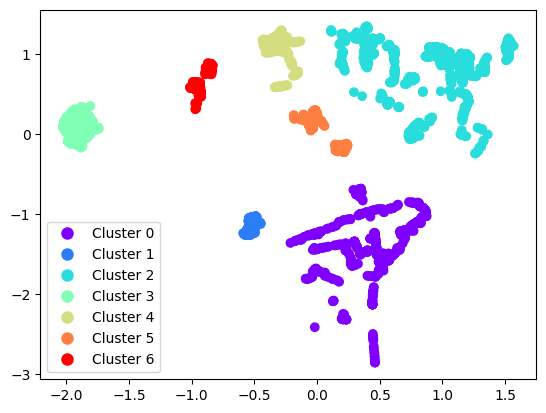

In [4]:
# open coordinates.xml file
tree = ET.parse("dataset/coordinates.xml")
root = tree.getroot()

# convert each entry to a point (id, latitude, longitude)
points = []
for entry in root.findall("entry"):
    id = entry.get("id")
    latitude = float(entry.find("latitude").text)
    longitude = float(entry.find("longitude").text)
    points.append((int(id), latitude, longitude))

# normalize the coordinates
points = np.array(points, dtype=float)
points[:, 1] = (points[:, 1] - points[:, 1].mean()) / points[:, 1].std()
points[:, 2] = (points[:, 2] - points[:, 2].mean()) / points[:, 2].std()



# use the coordinates to apply dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=2)
dbscan.fit(points[:, 1:])
labels = dbscan.labels_

# merge 0 and 4 (NOTE: assuming that there are 8 resulting clusters)
labels[labels == 4] = 0
labels[labels == 5] = 4
labels[labels == 6] = 5
labels[labels == 7] = 6

# get number of points per cluster
unique, counts = np.unique(labels, return_counts=True)

# create a list of rainbow colors, one color for each unique
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique)))




print(dict(zip(unique, counts)))

# plot the points and the centers
plt.scatter(points[:, 2], points[:, 1], c=[colors[i] for i in labels])
# add rainbow legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], label=f"Cluster {i}", markersize=10) for i in sorted(unique)])
# put legend on the right


plt.show()



In [5]:
clusters_counts = dict(zip(unique, counts))

train_clusters = [0, 2, 3]
test_clusters = [1, 4, 5, 6]

for i in range(len(test_clusters)):
    train_clusters.append(test_clusters[i])
    test_clusters[i] = -1

    train_cluster_counts = sum([clusters_counts[cluster] for cluster in train_clusters])
    print(train_clusters, test_clusters, train_cluster_counts/3146) # 3146 is the total number of images

    test_clusters[i] = train_clusters.pop()


[0, 2, 3, 1] [-1, 4, 5, 6] 0.7733630006357279
[0, 2, 3, 4] [1, -1, 5, 6] 0.8140495867768595
[0, 2, 3, 5] [1, 4, -1, 6] 0.8118245390972664
[0, 2, 3, 6] [1, 4, 5, -1] 0.770184361093452


##### We choose the split: [0,2,3,4], [1,5,6]

In [6]:
train_clusters = [0, 2, 3, 4]
test_clusters = [1, 5, 6]

### Adding "cluster" column & Checking sign distribution in the clusters

In [7]:
# 1 4 5 and 6 are the smallest clusters, and contain 27.7% of the images

# create a new column in the dataframe "cluster", init it to -1
df["cluster"] = -1

points = np.concatenate([points, labels.reshape(-1, 1)], axis=1)

# for each row in df, find the corresponding point and assign the cluster to the cluster column
for i, row in df.iterrows():
    filename = row["filename"]
    point = points[points[:, 0] == filename]
    assert len(point) == 1
    df.at[i, "cluster"] = point[0, 3]

Text(0.5, 1.0, 'Test Clusters')

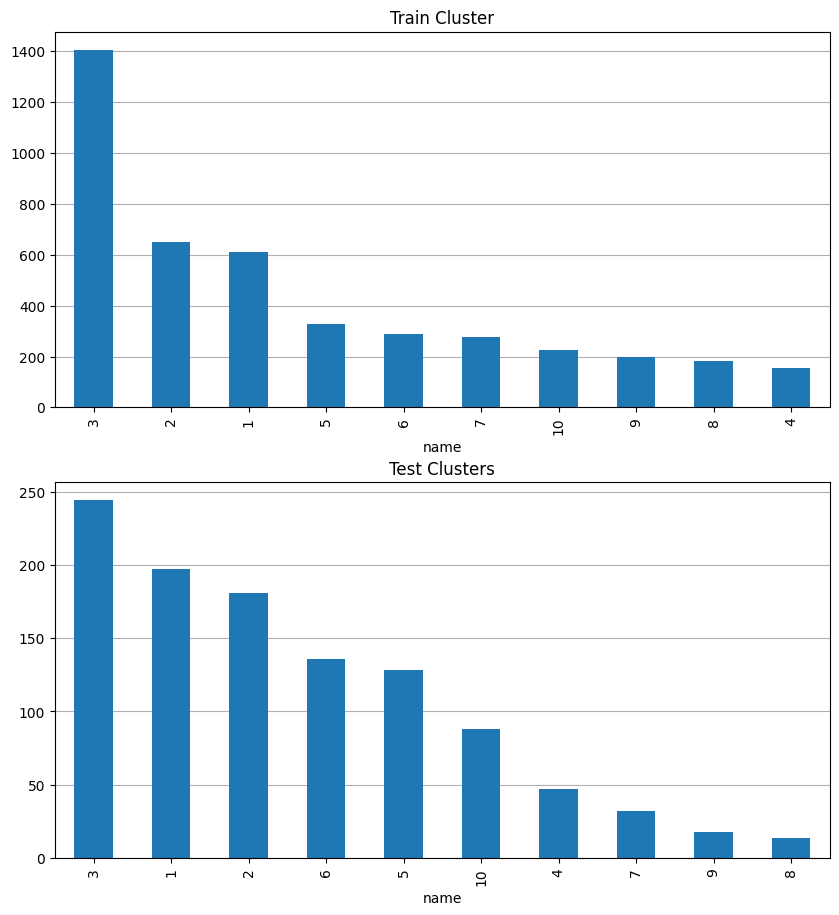

In [8]:
plt.figure(figsize=(10, 40))



plt.subplot(7, 1, 1)
d0 = df[df["cluster"] == 0]
d2 = df[df["cluster"] == 2]
d3 = df[df["cluster"] == 3]
d4 = df[df["cluster"] == 4]
# merge the dataframes
histogram = pd.concat([d0, d2, d3])["name"].value_counts()

# plot the histogram in the subplot
histogram.plot(kind="bar")
# add horizontal grid
plt.grid(axis="y")
# grid goes behind the bars
plt.gca().set_axisbelow(True)
plt.title(f"Train Cluster")

plt.subplot(7, 1, 2)
# get the rows with cluster not in 0, 2, 3, 4
dother = df[~df["cluster"].isin([0, 2, 3, 4])]
histogram = dother["name"].value_counts()

# plot the histogram in the subplot
histogram.plot(kind="bar")
#add horizontal grid
plt.grid(axis="y")
# grid goes behind the bars
plt.gca().set_axisbelow(True)
plt.title(f"Test Clusters")
    

### Creating the train and test splits (random and cluster based)

In [9]:
CREATE_SPLIT_FILES = False

In [10]:
# first, create a random 80-20 split of the data

if CREATE_SPLIT_FILES:
    train_ratio = sum([clusters_counts[cluster] for cluster in train_clusters]) / 3146
    print("train ratio:", train_ratio)

    # get all image file paths
    all_images = [os.path.join("dataset\\images", f) for f in os.listdir("dataset\\images") if f.endswith(".png")]
    random.seed(47)
    random.shuffle(all_images)

    # split into train and val
    train_count = int(len(all_images) * train_ratio)
    train_files = all_images[:train_count]
    val_files = all_images[train_count:]

    print(len(train_files), "train files,", len(val_files), "val files")

    # write to train.txt and test.txt
    with open("splits/random/train.txt", "w") as train_file:
        train_file.write("\n".join(train_files) + "\n")

    with open("splits/random/test.txt", "w") as test_file:
        test_file.write("\n".join(val_files) + "\n")

    print("Random split created successfully")

In [11]:
# now, let's create a split based on the clusters [0,2,3,4] for train and [1,5,6] for test
if CREATE_SPLIT_FILES:
    train_files = []
    test_files = []

    all_images = [os.path.join("dataset\\images", f) for f in os.listdir("dataset\\images") if f.endswith(".png")]

    for path in all_images:
        image_id = int(path.split("\\")[2].split(".")[0])
        image_cluster = df[df["filename"] == image_id]["cluster"].values[0]
        if image_cluster in train_clusters:
            train_files.append(path)
        else:
            assert image_cluster in test_clusters
            test_files.append(path)

    print(len(train_files), "train files,", len(test_files), "test files")

    # write to train.txt and test.txt
    with open("splits/cluster/train.txt", "w") as train_file:
        train_file.write("\n".join(train_files) + "\n")

    with open("splits/cluster/test.txt", "w") as test_file:
        test_file.write("\n".join(test_files) + "\n")

### First approach: YOLOv8

##### Random split

In [ ]:
# fine tune YOLOv8 (random split)

model = YOLO('yolov8n.pt') 

model.train(
    data='dataset (random).yaml',  
    epochs=50,            
    batch=64,             
    imgsz=512,             # image resolution
    workers=4,            
    device=0,              # GPU: 0 , 'cpu': CPU
    
    augment=False,
    hsv_h = 0.0,
    hsv_s = 0.0,
    hsv_v = 0.0,
    degrees = 0.0,
    translate = 0.0,
    scale = 0.0,
    shear = 0.0,
    perspective = 0.0,
    flipud = 0.0,
    fliplr = 0.0,
    mosaic = False,
    mixup = False
)

# validate model
metrics = model.val()

In [ ]:
# export model
model.export(format='torchscript')

##### Cluster split

In [ ]:
# fine tune YOLOv8 (cluster split)

model = YOLO('yolov8n.pt') 

model.train(
    data='dataset (cluster).yaml',  
    epochs=50,            
    batch=64,             
    imgsz=512,             # image resolution
    workers=4,            
    device=0,              # GPU: 0 , 'cpu': CPU
    
    augment=False,
    hsv_h = 0.0,
    hsv_s = 0.0,
    hsv_v = 0.0,
    degrees = 0.0,
    translate = 0.0,
    scale = 0.0,
    shear = 0.0,
    perspective = 0.0,
    flipud = 0.0,
    fliplr = 0.0,
    mosaic = False,
    mixup = False
)

# validate model
metrics = model.val()

In [ ]:
# export model
model.export(format='torchscript')

##### Cluster Split with data augmentation

In [ ]:
# fine tune YOLOv8 (cluster split) + data augmentation

model = YOLO('yolov8n.pt') 

model.train(
    data='dataset (cluster).yaml',  
    epochs=50,            
    batch=64,             
    imgsz=512,             # image resolution
    workers=4,            
    device=0,              # GPU: 0 , 'cpu': CPU
    
    augment=True,
    hsv_h = 0.015,
    hsv_s = 0.7,
    hsv_v = 0.4,
    degrees = 0.0,
    translate = 0.0,
    scale = 0.0,
    shear = 0.0,
    perspective = 0.0,
    flipud = 0.0,
    fliplr = 0.0,
    mosaic = 1.0,
    mixup = 0.5

)


# validate model
metrics = model.val()

In [ ]:
# export model
model.export(format='torchscript')

### Second approach: Faster RCNN

In [12]:
# dataset class

class RoadSignDetectionCT_Dataset(Dataset):
    def __init__(self, df, train = True, cluster_split = False, transform=None):
        self.df = df
        self.train = train
        self.transform = transform

        split = "train" if train else "test"

        if cluster_split:
            with open(f"splits/cluster/{split}.txt", "r") as f:
                self.image_filenames = f.read().split("\n")[:-1]
        else:
            with open(f"splits/random/{split}.txt", "r") as f:
                self.image_filenames = f.read().split("\n")[:-1]


        

    def __len__(self):
        return len(self.image_filenames)

    
    def __getitem__(self, idx):
        image = Image.open(self.image_filenames[idx])
        # get the image id
        image_id = int(self.image_filenames[idx].split("\\")[2].split(".")[0])
        # get the corresponding labels
        labels_ = self.df[self.df["filename"] == image_id]
        # get the width and height of the image
        width, height = image.size

        boxes = []
        labels = []
        for i, row in labels_.iterrows():
            xmin = row["xmin"]
            ymin = row["ymin"]
            xmax = row["xmax"]
            ymax = row["ymax"]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(row["name"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)
        

        if self.transform:
            image = self.transform(image)

        return image, target

##### Random split

In [ ]:
# import the model (fasterrcnn_resnet50_fpn)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(LABELS) + 1) #+ 1 because of the background class

In [ ]:
# before starting the training, check that the folder "fasterrcnn models - randomsplit" is empty

if os.path.exists("fasterrcnn models - randomsplit"):
    if len(os.listdir("fasterrcnn models - randomsplit")) > 0:
        raise Exception("The folder 'fasterrcnn models - randomsplit' is not empty")
else:
    #create folder
    os.mkdir("fasterrcnn models - randomsplit")

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = RoadSignDetectionCT_Dataset(df, train=True, cluster_split=False, transform=transform)
test_dataset = RoadSignDetectionCT_Dataset(df, train=False, cluster_split=False, transform=transform)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) 


# to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# training
num_epochs = 10


for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, test_loader, device)   


    torch.save(model.state_dict(), os.path.join("fasterrcnn models - randomsplit", f"fasterrcnn_epoch_{epoch}.pth"))



##### Cluster split

In [ ]:
# import the model (fasterrcnn_resnet50_fpn)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(LABELS) + 1) #+ 1 because of the background class

In [ ]:
# before starting the training, check that the folder "fasterrcnn models - clustersplit" is empty

if os.path.exists("fasterrcnn models - clustersplit"):
    if len(os.listdir("fasterrcnn models - clustersplit")) > 0:
        raise Exception("The folder 'fasterrcnn models - clustersplit' is not empty")
else:
    # create folder
    os.mkdir("fasterrcnn models - clustersplit")

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = RoadSignDetectionCT_Dataset(df, train=True, cluster_split=True, transform=transform)
test_dataset = RoadSignDetectionCT_Dataset(df, train=False, cluster_split=True, transform=transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) 



# to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# training
num_epochs = 10


for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, test_loader, device)

    torch.save(model.state_dict(), os.path.join("fasterrcnn models - clustersplit", f"fasterrcnn_epoch_{ epoch}.pth"))



##### Cluster split with data augmentation

In [ ]:
# updated class with data augmentation (mosaic and mixup)
class RoadSignDetectionCT_Dataset(Dataset):
    def __init__(self, df, train=True, cluster_split=False, transform=None, mosaic_probability=1.0, mixup_probability=0.5):
        self.df = df
        self.train = train
        self.transform = transform
        self.mosaic_probability = mosaic_probability  
        self.mixup_probability = mixup_probability    

        split = "train" if train else "test"

        # load image paths
        if cluster_split:
            with open(f"splits/cluster/{split}.txt", "r") as f:
                self.image_filenames = f.read().split("\n")[:-1]
        else:
            with open(f"splits/random/{split}.txt", "r") as f:
                self.image_filenames = f.read().split("\n")[:-1]

    def __len__(self):
        return len(self.image_filenames)
    

    def __getitem__(self, idx):
        if self.train:

            rand = random.random()
            was_mosaic = False
            if rand < self.mosaic_probability: 
                image,target = self._mosaic_augmentation(idx)
                was_mosaic = True
            else:
                image, target = self._load_image_and_annotations(idx)

            rand = random.random()
            if rand < self.mixup_probability:
                old_mosaic_probability = self.mosaic_probability
                old_mixup_probability = self.mixup_probability

                self.mixup_probability = 0.0
                self.mosaic_probability = 1.0 if was_mosaic else 0.0

                image2, target2 = self[random.randint(0, len(self) - 1)]


                # convert to PIL image
                image = transforms.ToPILImage()(image)
                image2 = transforms.ToPILImage()(image2)

                # if the two images have different sizes, resize to 512x512
                if image.size != image2.size:
                    image = image.resize((512, 512))
                    image2 = image2.resize((512, 512))

                self.mosaic_probability = old_mosaic_probability
                self.mixup_probability = old_mixup_probability
                
                alpha = random.uniform(0.4, 0.6)
                image = Image.blend(image, image2, alpha)
                target["boxes"] = torch.cat((target["boxes"], target2["boxes"]), dim=0)
                target["labels"] = torch.cat((target["labels"], target2["labels"]), dim=0)

                # convert image back to tensor
                image = transforms.ToTensor()(image)

            if len(target["boxes"]) == 0:
                image, target = self[random.randint(0, len(self) - 1)]

        else:
            image, target = self._load_image_and_annotations(idx)

        
        return image, target

    def _load_image_and_annotations(self, idx, skip_transform=False):
        # load image and annotations
        image = Image.open(self.image_filenames[idx])
        image_id = int(self.image_filenames[idx].split("\\")[2].split(".")[0])
        labels_ = self.df[self.df["filename"] == image_id]

        # get image size
        width, height = image.size

        # extract bounding boxes and labels
        boxes = []
        labels = []
        for i, row in labels_.iterrows():
            xmin = row["xmin"]
            ymin = row["ymin"]
            xmax = row["xmax"]
            ymax = row["ymax"]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(row["name"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": idx,
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64),
        }

        if self.transform and not skip_transform:
            image = self.transform(image)

        return image, target

    def _mosaic_augmentation(self, idx):
        # select 4 random images
        indices = [random.randint(0, len(self.image_filenames) - 1) for _ in range(4)]
        images, targets = zip(*(self._load_image_and_annotations(i, skip_transform=True) for i in indices))

        # combine the images into one mosaic
        mosaic_size = 1024  # size of the final mosaic image
        mosaic_image = Image.new("RGB", (mosaic_size, mosaic_size))
        mosaic_boxes = []
        mosaic_labels = []

        # top-left, top-right, bottom-left, bottom-right
        positions = [(0, 0), (mosaic_size // 2, 0), (0, mosaic_size // 2), (mosaic_size // 2, mosaic_size // 2)]
        for img, target, (x_offset, y_offset) in zip(images, targets, positions):
            original_width, original_height = img.width, img.height

            img = img.resize((mosaic_size // 2, mosaic_size // 2)) 

            mosaic_image.paste(img, (x_offset, y_offset))

            # adjust bounding boxes
            for box in target["boxes"]:
                xmin, ymin, xmax, ymax = box.tolist()
                xmin = xmin * (mosaic_size // 2) /  original_width + x_offset
                xmax = xmax * (mosaic_size // 2) / original_width + x_offset
                ymin = ymin * (mosaic_size // 2) / original_height + y_offset
                ymax = ymax * (mosaic_size // 2) / original_height + y_offset
                mosaic_boxes.append([xmin, ymin, xmax, ymax])

            mosaic_labels.extend(target["labels"].tolist())

        mosaic_boxes = torch.as_tensor(mosaic_boxes, dtype=torch.float32)
        mosaic_labels = torch.as_tensor(mosaic_labels, dtype=torch.int64)

        target = {
            "boxes": mosaic_boxes,
            "labels": mosaic_labels,
            "image_id": idx,
            "area": (mosaic_boxes[:, 3] - mosaic_boxes[:, 1]) * (mosaic_boxes[:, 2] - mosaic_boxes[:, 0]),
            "iscrowd": torch.zeros((len(mosaic_labels),), dtype=torch.int64),
        }

        if self.transform:
            mosaic_image = self.transform(mosaic_image)
        
        # perform a random crop
        crop_width, crop_height = round(mosaic_size / 1.5), round(mosaic_size / 1.5)
        i, j, h, w = transforms.RandomCrop.get_params(mosaic_image, output_size=(crop_height, crop_width))
        mosaic_image = F.crop(mosaic_image, i, j, h, w)

        # adjust bounding boxes for the crop
        cropped_boxes = []
        cropped_labels = []

        for box, label in zip(target["boxes"], target["labels"]):
            xmin, ymin, xmax, ymax = box
            xmin = xmin - j
            xmax = xmax - j
            ymin = ymin - i
            ymax = ymax - i

            # ensure the box is still valid after cropping
            if xmax > 0 and ymax > 0 and xmin < crop_width and ymin < crop_height:
                # clip the box to be within the crop area
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(crop_width, xmax)
                ymax = min(crop_height, ymax)
                cropped_boxes.append([xmin, ymin, xmax, ymax])
                cropped_labels.append(label)

        # update target with cropped boxes and labels
        target["boxes"] = torch.as_tensor(cropped_boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(cropped_labels, dtype=torch.int64)
        

        return mosaic_image, target

In [ ]:
# plot some examples of mosaic augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # hue: 0.015, saturation: 0.7, brightness: 0.4
    transforms.ColorJitter(hue=0.015, saturation=0.7, brightness=0.4)
])
dataset = RoadSignDetectionCT_Dataset(df, train=False, cluster_split=True, transform=transform, mosaic_probability=1.0, mixup_probability=0.5)
mosaic_image, target = dataset[0]

# convert tensor to PIL image
mosaic_image = F.to_pil_image(mosaic_image)

# draw bounding boxes
draw = ImageDraw.Draw(mosaic_image)
for box in target["boxes"]:
    xmin, ymin, xmax, ymax = box.tolist()
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red")

for i, label in enumerate(target["labels"]):
    xmin, ymin, xmax, ymax = target["boxes"][i].tolist()
    draw.text((xmin, ymin), LABELS[int(label.item())-1], fill="red", fontsize = 100)


plt.figure(figsize=(10, 10))
plt.imshow(mosaic_image)

In [ ]:
# import the model (fasterrcnn_resnet50_fpn)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(LABELS) + 1) #+ 1 because of the background class

In [ ]:
# before starting the training, check that the folder "fasterrcnn models - clustersplit" is empty

if os.path.exists("fasterrcnn models - clustersplit augmentation"):
    if len(os.listdir("fasterrcnn models - clustersplit augmentation")) > 0:
        raise Exception("The folder 'fasterrcnn models - clustersplit augmentation' is not empty")
else:
    # create folder
    os.mkdir("fasterrcnn models - clustersplit augmentation")

In [ ]:
# dataloaders

# define transform for images

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.015, saturation=0.7, brightness=0.4)
])

train_dataset = RoadSignDetectionCT_Dataset(df, train=True, cluster_split=True, transform=transform, mosaic_probability=1.0, mixup_probability=0.5)
test_dataset = RoadSignDetectionCT_Dataset(df, train=False, cluster_split=True, transform=transform)

# dataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) 




# to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# training
num_epochs = 8

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, test_loader, device)

    torch.save(model.state_dict(), os.path.join("fasterrcnn models - clustersplit augmentation", f"fasterrcnn_epoch_{ epoch}.pth"))




In [ ]:
train_dataset_last2epochs = RoadSignDetectionCT_Dataset(df, train=True, cluster_split=True, transform=transform, mosaic_probability=0.0, mixup_probability=0.5)
train_loader_last2epochs = DataLoader(train_dataset_last2epochs, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

print("--- last 2 epochs, mosaic augmentation disabled ---")

# do 2 more epochs without mosaic augmentation
for epoch in range(2):
    train_one_epoch(model, optimizer, train_loader_last2epochs, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, test_loader, device)

    torch.save(model.state_dict(), os.path.join("fasterrcnn models - clustersplit augmentation", f"fasterrcnn_epoch_{ epoch + num_epochs}.pth"))